# Bessel functions by recursion

## 1.)upward recursion

First we take care of a special case of very small $x$. In this case only $j_0=1$ and all $j_{l>0}=0$. We want to do that first, because it is numerically hard to evaluate even $j_1$ using definition $j_1(x)=j_0(x)/x-\cos(x)/x$, when $x$ is almost exactly zero.

Next we set up the iteration by evaluating $j_0=\sin(x)/x$ and $j_1=j0(x)/x-\cos(x)/x$.

Before storing $j_1$ into array, we need to check that $l>0$ was requested. We store $j_1$ and then enter the loop, computing $j_2$ from $j_1$ and $j_0$. We repeat the following recursive relation (starting with $i=1$ and looping up to requested $i=l-1$):

\begin{eqnarray}
j_{i+1}(x)=\frac{2i+1}{x}j_i-j_{i-1}
\end{eqnarray}
In the loop, we always store $j_{i+1}$ as soon as we compute it.


In [1]:
from scipy import *

def bessel_upward(l,x):
    """Upward recursion to compute the spherical bessel function.
       returns the list of all l's [0,...l]
    """
    if abs(x)<1e-20:
        res=zeros(l+1)
        res[0]=1.
        return res

    j0 = sin(x)/x
    j1 = j0/x-cos(x)/x
    res=[j0]
    if l==0: return array(res)
    res.append(j1)
    for i in range(1,l):
        j2 = (2*i+1)/x*j1-j0
        res.append(j2)
        j0=j1
        j1=j2
        
    return array(res)


In [2]:
from scipy import special
l=10
x=0.1
dat0=bessel_upward(l,x)
dat1=special.sph_jn(l,x)[0]
print 'difference=', abs(dat1-dat0)
print 'exact=', dat1
print 'upward recursion=', dat0

difference= [  1.11022302e-16   1.38777878e-16   4.28823643e-15   2.14271068e-13
   1.49946867e-11   1.34930753e-09   1.48408833e-07   1.92917990e-05
   2.89362145e-03   4.91896354e-01   9.34574137e+01]
exact= [  9.98334166e-01   3.33000119e-02   6.66190608e-04   9.51851972e-06
   1.05772015e-07   9.61631023e-10   7.39754109e-12   4.93188748e-14
   2.90120010e-16   1.52698569e-18   7.27151100e-21]
upward recursion= [  9.98334166e-01   3.33000119e-02   6.66190608e-04   9.51851994e-06
   1.05787010e-07   2.31093855e-09   1.48416231e-07   1.92917991e-05
   2.89362145e-03   4.91896354e-01   9.34574137e+01]


## 2.) downward recursion

If $l\gg x$ we know that Neuman function $n_l(x)$ is larger than $j_l(x)$, and since the Neuman function is also a solution of the same recursion relation, it will start to dominate the result no matter how precise the numerics is.
 
Looking at the iteration we see that at large $l$ and small $x$, the two terms in the recursion relation are almost equal and subtract, hence the error grows very rapidly. Lets check $l=10$ and $x=0.1$, and try to compute $l=11$, i.e.,
\begin{eqnarray}
j_{11}=\frac{21}{x} j_{10}-j_9
\end{eqnarray}
and we see that $21/x j_{10}$ is almost the same as $j_9$, hence taking the difference creates a huge error.

In [3]:
jn=special.sph_jn(10,0.1)[0]
print 21/0.1*jn[10]
print jn[9]
print 21/0.1*jn[10]-jn[9]

1.52701730931e-18
1.52698569349e-18
3.16158150517e-23


We hence need to invent different strategy.
One possible strategy is to use so called Miller's algorithm, where we start iteration at large $l$ and iterate downwards to smaller $l$, using an equivalent iteration:
\begin{eqnarray}
j_{i-1}(x)=\frac{2i+1}{x}j_i-j_{i+1}
\end{eqnarray}

We need to start the recursion at sufficiently large $l_{start}$. For example $l_{start}=l+\sqrt{10 l}$ is a safe choice. We can choose $j_{l_{start}}=0$ and $j_{l_{start}-1}$ is any constant. This is becuase the recursion relation is linear, and we are allowed to multiply the entire series by an arbitrary constant, which just rescales all terms in the series, i.e., $j_i \rightarrow j_i * const$.

A convenient choice is $j_{l_{start}-1}=1$, which than determines our choice of $const$.

Once our recursion comes down to $j_0$, we can compare the correct value of $j_0$ and recursively obtained $j_0$, and this comparison determines the value of the $const$.

We then rescale all $j_i$ by this constant.


In [4]:
def bessel_downward(l,x):
    "Downward recursion to compute the spherical bessel function."
    if abs(x)<1e-20:
        res=zeros(l+1)
        res[0]=1.
        return res
    lstart = l + int(sqrt(10*l))
    j2=0.
    j1=1.
    res=[]
    for i in range(lstart,0,-1):
        j0 = (2*i+1)/x*j1-j2   # j_0 is actually j_{i-1}
        if i-1<=l : res.append(j0) # hence store j_l, which occurs when l>=i-1
        j2=j1
        j1=j0
    true_j0 = sin(x)/x
    res.reverse()
    res = array(res)*true_j0/res[0]  # Since the recursion relation is linear, we can normalize all j_l's.
    return res


In [5]:
from scipy import special
l=10
x=0.1
dat0=bessel_downward(l,x)
dat1=special.sph_jn(l,x)[0]
print 'difference=', abs(dat1-dat0)
print 'exact=', dat1
print 'downward recursion=', dat0

difference= [  1.11022302e-16   6.93889390e-18   0.00000000e+00   1.69406589e-21
   1.32348898e-23   2.06795153e-25   1.61558713e-27   2.52435490e-29
   1.47911420e-31   5.77778983e-34   4.51389831e-36]
exact= [  9.98334166e-01   3.33000119e-02   6.66190608e-04   9.51851972e-06
   1.05772015e-07   9.61631023e-10   7.39754109e-12   4.93188748e-14
   2.90120010e-16   1.52698569e-18   7.27151100e-21]
downward recursion= [  9.98334166e-01   3.33000119e-02   6.66190608e-04   9.51851972e-06
   1.05772015e-07   9.61631023e-10   7.39754109e-12   4.93188748e-14
   2.90120010e-16   1.52698569e-18   7.27151100e-21]


## 3.) Finally combine the upward and downward recursion

If $l<x$ we can use upward recursion, and if $l>x$ we should use downward recursion.
We should calculate the value of $l_{critical}\approx x$, at which we need to change the strategy.

We then use for $l<l_{critical}$ the upward recursion, and for $l>=l_{critical}$ the downward recursion.

We can immediately return upward recursion values, if $l_{max}<x$. And if $x<1$ we should use downward recursion only.


In [6]:
def besselj(l,x):
    if l<=x : return bessel_upward(l,x)
    # for l<x : still use upward
    # for l>x : use downward
    lcritical = int(x)
    if lcritical<=0: return bessel_downward(l,x) # for very small x, only downward
    if lcritical>=l: return bessel_upward(l,x) # for large x, only upward
    _ju = bessel_upward(lcritical-1,x)
    _jd = bessel_downward(l,x)
    return hstack( (_ju ,_jd[lcritical:]) )

In [7]:
l=10
x=100.
dat0 = special.sph_jn(l,x)[0]

dat1 = bessel_upward(l,x)
dat2 = bessel_downward(l,x)
dat3 = besselj(l,x)

print 'from library=',dat0
print 'upward recur=',dat1
print 'downward recur=',dat2
print 'best recur=',dat3
print 
print 'difference=', abs(dat3-dat0)

from library= [-0.00506366 -0.00867383  0.00480344  0.008914   -0.00417946 -0.00929015
  0.00315755  0.00970063 -0.00170245 -0.00999005 -0.00019566]
upward recur= [-0.00506366 -0.00867383  0.00480344  0.008914   -0.00417946 -0.00929015
  0.00315755  0.00970063 -0.00170245 -0.00999005 -0.00019566]
downward recur= [-0.00506366 -0.00550685  0.00489845  0.00575177 -0.00449583 -0.0061564
  0.00381862  0.00665282 -0.0028207  -0.00713234  0.00146556]
best recur= [-0.00506366 -0.00867383  0.00480344  0.008914   -0.00417946 -0.00929015
  0.00315755  0.00970063 -0.00170245 -0.00999005 -0.00019566]

difference= [  4.51028104e-17   0.00000000e+00   4.51028104e-17   1.73472348e-18
   4.42354486e-17   6.93889390e-18   4.38017678e-17   1.21430643e-17
   4.16333634e-17   1.73472348e-17   3.83265468e-17]


Loading BokehJS ...

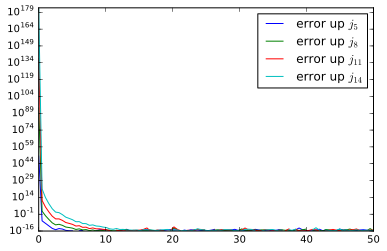

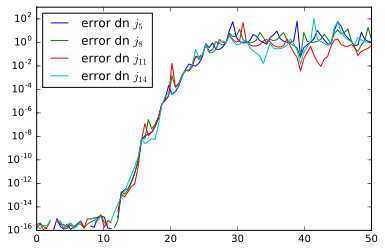

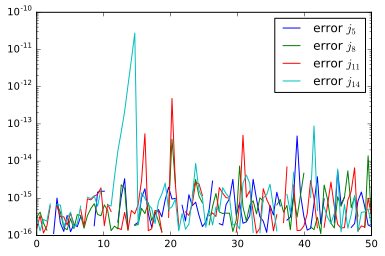

In [15]:
from pylab import *
# The next few lines are not necessary, but it will make plots nicer
# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting
# This line is necessary for inline plotting
%matplotlib inline

# The next two lines are not necessary, but the plots look nicer with them
# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'svg',}
# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

l=15
x = linspace(1e-6,50,100)
    
jn0 = array([special.sph_jn(l,t)[0] for t in x])
jn1 = array([bessel_upward(l,t) for t in x])
jn2 = array([bessel_downward(l,t) for t in x])
jn3 = array([besselj(l,t) for t in x])

for i in range(5,15,3):
    semilogy(x, abs(jn1[:,i]-jn0[:,i])/abs(jn0[:,i]), label='error up $j_{'+str(i)+'}$' )
legend(loc='best')
show()

for i in range(5,15,3):
    semilogy(x, abs(jn2[:,i]-jn0[:,i])/abs(jn0[:,i]), label='error dn $j_{'+str(i)+'}$' )
legend(loc='best')
show()

for i in range(5,15,3):
    semilogy(x, abs(jn3[:,i]-jn0[:,i])/abs(jn0[:,i]), label='error $j_{'+str(i)+'}$' )
legend(loc='best')
show()



## 4.) How to speed up the calculation by weave?

In [18]:
from scipy import weave
import os

def besselw(l,t):
    code="""
    besselj(res,l,t);
    """
    res=zeros(l+1)
    weave.inline(code, ['res','l','t'], headers=['"sbessel.h"'],
            include_dirs=[os.getcwd(),sys.exec_prefix+'/lib/python2.7/site-packages/scipy/weave/blitz/'],
            type_converters=weave.converters.blitz, 
            compiler = 'gcc')
    return res

In [19]:
import time
l=30
x = linspace(1e-6,50,100000)
    
t0=time.clock()
jn0 = array([special.sph_jn(l,t)[0] for t in x])
t1=time.clock()
print 'time=', t1-t0
jn3 = array([besselj(l,t) for t in x])
t2=time.clock()
print 'time=',t2-t1
jn4 = array([besselw(l,t) for t in x])
t3=time.clock()
print 'time=', t3-t2
    

time= 1.194128


/Users/haule/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in double_scalars
/Users/haule/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


time= 3.74477
time= 1.263314


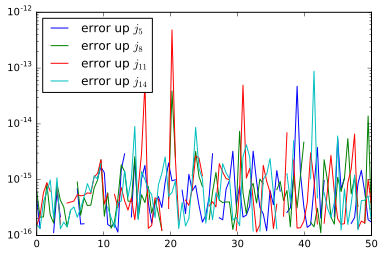

In [21]:
l=15
x = linspace(1e-6,50,100)
    
jn0 = array([special.sph_jn(l,t)[0] for t in x])
jn1 = array([besselw(l,t) for t in x])

for i in range(5,15,3):
    semilogy(x, abs(jn1[:,i]-jn0[:,i])/abs(jn0[:,i]), label='error up $j_{'+str(i)+'}$' )
legend(loc='best')
show()

